In [1]:
#코랩 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#env 모듈 임포트 경로 설정
import sys
sys.path.append("/content/drive/MyDrive/RL 실습")
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/RL 실습']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from environment import GraphicDisplay, Env

In [4]:
#환경(그리드)에 대한 기본 정보
print("가로: {}".format(Env().width))
print("세로: {}".format(Env().height))

가로: 5
세로: 5


In [5]:
#환경의 상태들
Env().get_all_states()[:5]

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

In [6]:
#에이전트 행동 공간
Env().possible_actions

[0, 1, 2, 3]

In [7]:
#환경에서 상태 가져오기
Env().state_after_action([1, 2], 3)

[1, 3]

In [8]:
#환경에서 보상 가져오기
print("보상 1 : {}".format(Env().get_reward([2, 1], 3)))
print("보상 2 : {}".format(Env().get_reward([2, 0], 3)))

보상 1 : 1
보상 2 : -1


In [9]:
#가치 초기화 형태
np.zeros((5,5)).tolist()

[[0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0]]

Agent

In [23]:
class PolicyIteration:
  def __init__(self, env):
    #환경 객체 선언
    self.env = env
    #가치함수 2차원 리스트 초기화
    self.value_table = np.zeros((env.width, env.height)).tolist()
    #정책 초기화
    self.policy_table = np.full((env.width, env.height, 4), 0.25).tolist()
    #종결 상태의 설정
    self.policy_table[2][2] = []
    #할인율
    self.discount_factor = 0.9

  #정책 평가
  def policy_evaluation(self):
    #V_new 초기화
    next_value_table = np.zeros((self.env.width, self.env.height)).tolist()

    #모든 상태에 대해서 벨만 기대 방정식 계산(인덱스 순의 상태로 업데이트)
    for state in self.env.get_all_states():
      value = 0.0
      #종결 상태 가치 = 0
      if state == [2, 2]:
        next_value_table[state[0]][state[1]] = value
        continue
      #벨만 기대 방정식
      for action in self.env.possible_actions:
        next_state = self.env.state_after_action(state, action)
        reward = self.env.get_reward(state, action)
        next_value = self.get_value(next_state)
        value += self.get_policy(state)[action] * (reward + self.discount_factor*next_value)
      next_value_table[state[0]][state[1]] = value

    new_value = np.array(next_value_table).flatten()
    old_value = np.array(self.value_table).flatten()
    value_err = np.linalg.norm(new_value - old_value)

    #모든 상태에 대해서 계산 한 후(한번의 벨만 기대 백업 오퍼레이터를 수행한 것) 업데이트
    self.value_table = next_value_table
    return value_err

  #현재 가치함수에 대해서 탐욕 정책 발전
  def policy_improvement(self):
    self.next_policy = self.policy_table
    for state in self.env.get_all_states():
      if state == [2, 2]:
        continue
      
      q_value_list = [] 
      #반환할 정책 초기화
      result = [0.0, 0.0, 0.0, 0.0]
      #q값 계산(상태 천이 확률 = 1 가정)
      for index, action in enumerate(self.env.possible_actions):
        next_state = self.env.state_after_action(state, action)
        reward = self.env.get_reward(state, action)
        next_value = self.get_value(next_state)
        q_value = reward + self.discount_factor*next_value
        q_value_list.append(q_value)

      #q값 최대인 행동에 대하여 탐욕 정책 발전
      max_idx_list = np.argwhere(q_value_list == np.amax(q_value_list))
      max_idx_list = max_idx_list.flatten().tolist()
      prob = 1 / len(max_idx_list)

      for idx in max_idx_list:
        result[idx] = prob
      
      self.next_policy[state[0]][state[1]] = result

    self.policy_table = self.next_policy
    
  #상태에 따른 정책 반환
  def get_policy(self, state):
    return self.policy_table[state[0]][state[1]]
  
  #상태에 따른 가치 반환
  def get_value(self, state):
    return self.value_table[state[0]][state[1]]
    
  #특정 상태에서 정책에 따라 무작위로 행동 반환
  def get_action(self, state):
    policy = self.get_policy(state)
    policy = np.array(policy)
    return np.random.choice(4, 1, p=policy)[0]

In [24]:
#그리드 Show 함수
def show(agent_state):

  dis = dict()
  state_len = len(Env().get_all_states())

  terminal_list = [[0,0], [2,2]]
  terminal_idxes = []

  state_idx = Env().get_all_states().index(agent_state)

  for state in range(state_len):
    dis[state] = "o"

  for terminal in terminal_list:
    idx = Env().get_all_states().index(terminal)
    terminal_idxes.append(idx)

  for terminal_idx in terminal_idxes:
    dis[terminal_idx] = "T"

  if state_idx in terminal_idxes:
    dis[state_idx] = "x" 
  else:
    dis[state_idx] = "x" 
  
  grid = ""
  for i in range(state_len):
    if (i+1) % Env().width != 0:
      grid += " " + dis[i]
    else:
      grid += " " + dis[i] + "\n"
  
  return print(grid)

In [25]:
print("[start]")
show([1, 0])

[start]
 T o o o o
 x o o o o
 o o T o o
 o o o o o
 o o o o o



Generalized Policy Iteration

In [26]:
#정책 이터레이션(GPI) 알고리즘 실행
#PI, PE 한 번씩 번갈아가며 실행 

class Iterator:
  def __init__(self):
    self.env = Env()
    self.agent = PolicyIteration(self.env)

  def iterate(self, error_tol=1e-5):

    value_tables = []
    value_errs = []
    steps = 0

    while True:
      steps += 1
      value_err = self.agent.policy_evaluation()
      self.agent.policy_improvement()
      value_tables.append(self.agent.value_table)
      value_errs.append(err)

      if err <= error_tol:
        print("err: {}".format(err))
        print("steps: {}".format(steps))
        break
    
    return value_tables, value_errs

  def run(self):
    state = [0, 0]
    t = 0
    while True:
      t += 1
      action = self.agent.get_action(state)
      next_state = self.env.state_after_action(state, action)
      print("{} iteration".format(t))
      show(next_state)
      state = next_state
      
      if state == [2, 2]:
        break

In [27]:
iterator = Iterator()

In [28]:
value_tables, value_errs = iterator.iterate()

err: 0.0
steps: 8


In [29]:
print("가치 테이블 shape: {}".format(np.array(value_tables).shape))

가치 테이블 shape: (8, 5, 5)


In [30]:
#행동 관찰
iterator.run()

1 iteration
 T x o o o
 o o o o o
 o o T o o
 o o o o o
 o o o o o

2 iteration
 T o x o o
 o o o o o
 o o T o o
 o o o o o
 o o o o o

3 iteration
 T o o x o
 o o o o o
 o o T o o
 o o o o o
 o o o o o

4 iteration
 T o o o o
 o o o x o
 o o T o o
 o o o o o
 o o o o o

5 iteration
 T o o o o
 o o o o o
 o o T x o
 o o o o o
 o o o o o

6 iteration
 T o o o o
 o o o o o
 o o x o o
 o o o o o
 o o o o o



In [31]:
#정책 개선 확인 (모든 상태에 대하여 가치함수 단조 증가)
env = Env()
agent = PolicyIteration(env)

for i in range(2):
  if i == 0:
    err = agent.policy_evaluation()
    before = agent.value_table
  elif i == 1:
    agent.policy_improvement()
    agent.policy_evaluation()
    after = agent.value_table

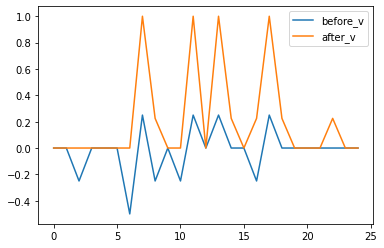

In [32]:
plt.plot(np.array(before).flatten(), label="before_v")
plt.plot(np.array(after).flatten(), label="after_v")
plt.legend()

In [33]:
#가치 테이블 시각화
def visualizer(data):
  data = np.array(data)
  len = data.shape[0]
  plt.figure(figsize=(20, 12))

  for i in range(len):
    plt.subplot(4, len-4, i+1)
    sns.heatmap(value_tables[i], annot=True, 
                cmap="PuBu", vmin=0, vmax=1, cbar=False)
    
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    plt.title("{} update".format(i+1))
  
  plt.show()

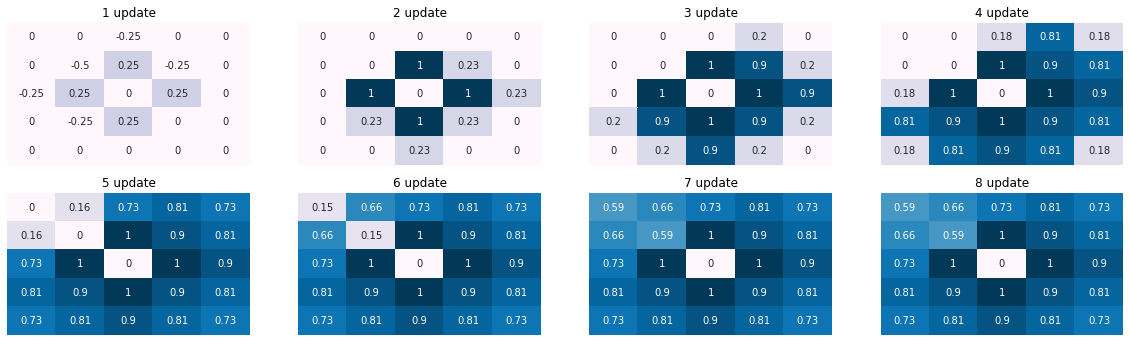

In [34]:
#가치함수 변화
visualizer(value_tables)